This notebook fits transmittance vs tangent altitude and evaluates the inverse Abel integral equation to determine pseudo-density. We will use the following definitions for transmittance $T$ as a function of tangent altitude $h$ and radial altitude $r$:

$$T(h, E) = \text{exp} \left(-\Gamma(h, E) \right)$$ and $$T(r, E) = \text{exp} \left( -\int \gamma(r, E) ds \right)$$.

Tangent altitude is $h$, radius to the tangent point is $y=h+y_{0,ref}$ where $y_{0,ref} = \max(R_{planet})+h_{0,ref}$ ($h_{0,ref} \sim 40$km). is the radius of the reference sphere used for navigation. The radial geocentric distance is $r$ and $s$ spans the telescopic line of sight. Optical depth is $\Gamma$ and "atmospheric depth" or "pseudo-density" is $\gamma(r, E)=\sigma(E) n(r)$ (pseudo-density). This is similar to the convention that column density is $N(h)$ and number density is $n(r)$ used by Roble and Hays (https://www.sciencedirect.com/science/article/abs/pii/0032063372901948), but I am not defining cross section. I decided to do this because it decouples the atomic physics and the navigational problem and it will probably make post-processing for atmospheric science easier.

For the purpouse of navigation, we fit $\Gamma(h)$ to the data, then we reconstruct the "smooth model" (this replaces the transmission model previouslt calculated by integrating the telescope's LOS), but in order to actually get a useful measurement, we replace h_50 with the filter's estimation.

In order to analyze the atmosphere and make use of the spherically-stratified assumption, the first step is to convert $h$ into $y=y_{0,ref}+h$. In a spherically-straified atmosphere where the satelite is at $s=\infty$, we can determine optical depth by integrating pseudo-density along the line of sight:

$$\Gamma(y) = 2 \int_y^\infty \gamma (r) ds$$ where $y^2+s^2=r^2$. Therefore, we can derive the version of the Abel integral that is used in density retrieval: $$\Gamma(y) = 2 \int_y^\infty \frac{\gamma(r)r}{\sqrt{r^2-y^2}}dr$$ The inverse Abel integral can be derived with Laplace transforms, and is given by 

$$\gamma(r) = -\frac{1}{\pi} \int_r^{\infty} \frac{\frac{\text{d}\Gamma(y)}{\text{d}y}}{\sqrt{y^2-r^2}}\text{d}y$$ This is the equation that must be solved when measuring atmospheric density. For a given energy band, $\sigma(E)$ is a constant that can be defined as the center of the energy band (or slightly differently based on the source spectrum), and the density can be determined by $n(r)=\gamma(r)/\sigma(E)$.

In [1]:
# Build the integrand. With the change of variables h=z/(1-z)+r, we can integrate wrt z = [0, 1]
import sympy as sp
y, f, z, r, N, D, I = sp.symbols("y f z r N D I", real=True)   # used in the Abel transform, N is the numerator, D is denominator, I is integrand
a, b, c, d = sp.symbols("a b c d", real=True)  # fit parameters
y=(z/(1-z))+r   # Either keep or highlight this 
N = -a*𝑏/(a*sp.sinh(b*(y-c)) + d*sp.cosh(b*(y-c)))  # Numerator. Alternate form: 2 b csch(2 b (c - h))
D = sp.sqrt(y**2-r**2)    # Denominator
I = (-1/sp.pi)*(N/D)/(1-z**2)
I

a*b/(pi*(1 - z**2)*sqrt(-r**2 + (r + z/(1 - z))**2)*(a*sinh(b*(-c + r + z/(1 - z))) + d*cosh(b*(-c + r + z/(1 - z)))))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

R_planet = 6367.8   # km, radius of Earth at tangent point (this is like 'y_0,ref' above)

## It is important to note that the data being readd into this file uses an ellipsoid Earth,
## so we're not looking for exact constistency... just order of magnitude.

timeTransmit = np.load("timeTransmit.npy")
time_data = timeTransmit[:,0]
transmit_data = timeTransmit[:,1]
timeAlt = np.load("timeAlt.npy")
time_crossing_model = timeAlt[:,0]
y_list = timeAlt[:,1]+R_planet  # Note that this would be "y" in my new notation

crossing_range = np.where((time_data>=time_crossing_model[0])&(time_data<=time_crossing_model[-1]))[0]
time_data = time_data[crossing_range]
transmit_data = transmit_data[crossing_range]

# 1) Since the transmit data doesnt correspond to time_crossing_model, we first need to interpolate h_list
# We can avoid this is the future by by definining time_crossing_model differently in another script so that instead of t0_model+[0:175:1], it is t0_model+[dt1:175+dt1:1] where dt1 = time_data[0] - t0_model... but the interpolation is fine for this example
y_vs_time = interp1d(time_crossing_model, y_list, "cubic")
time_vs_y = interp1d(y_list, time_crossing_model, "cubic")
y_data = y_vs_time(time_data)

In [3]:
w1 = np.where(transmit_data>=0.01)[0][0]  # can't go to zero
w2 = np.where(transmit_data >= 0.99)[0][0]  # could also use -1

transmit_measured = transmit_data[w1:w2]
y_measured = y_data[w1:w2]
Gamma_measured = -np.log(transmit_measured)

# Try the tanh() fit on transmittance:

Text(0.5, 0, 'Tangent Altitude (km)')

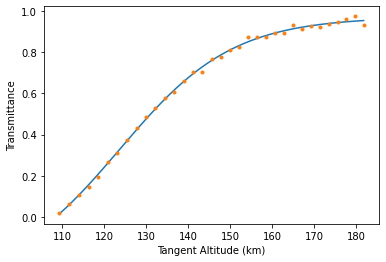

In [4]:
# we can fit to either y or h, the c parameter is the only thing that will change
def transmit_vs_y(y, a, b, c, d):
    return a*np.tanh(b*(y-c))+d

popt, pcov = curve_fit(transmit_vs_y, y_measured, transmit_measured, p0=[0.5, 1/50, 100+6378, 0.5])
a, b, c, d = popt

y = np.linspace(np.min(y_measured), np.max(y_measured), 1000)
plt.plot(y-R_planet, transmit_vs_y(y, *popt))
plt.plot(y_measured-R_planet, transmit_measured, ".")   # fit y, plot h
plt.ylabel("Transmittance")
plt.xlabel("Tangent Altitude (km)")

a: height of the curve to the center (either 0.5 or 0.5*unnatenuated_rate)

b: Verticality of the curve (positive for rising, negative for setting, b0 = (expected duration in tangent alt)^-1).

c: The left/right slide of center point in the tangent altitude domain (h=100+R_planet)

d: transmittance value at the 50% point (either 0.5 or 0.5unnatenuated_rate)

None of the initial guesses are very sensitive. The 'c' parameter can be added to the filter. I think that we can characterize all the errors due to the atmosphere with the c parameter. This can depend on ~four factors, for which we can create models based on existing data.
"d" needs to be enforced as 0.5*unattenuated rate if we don't want the fit curve to go under zero. We don't need to enfore "d", but we must make sure to limit the valid domain of the tanh() function fit.

In [5]:
print(f"a={a}, b={b}, c={c}, d={d}")

a=0.6424537647159534, b=0.03713331122385225, c=6491.483824849571, d=0.3289429650111349


Text(0.5, 0, 'Tangent Altitude (km)')

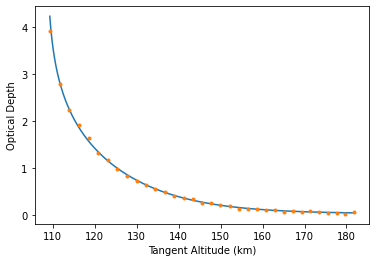

In [6]:
transmit_model = transmit_vs_y(y, *popt)
Gamma_model = -np.log(transmit_model)
# log argument can't be negative, which means we need to be careful near the bottom of the transmittance curve
# The fit definitely is worse and worse near the bottom

plt.plot(y-R_planet, Gamma_model)
plt.plot(y_measured-R_planet, Gamma_measured,'.')
plt.ylabel("Optical Depth")
plt.xlabel("Tangent Altitude (km)")

Text(0.5, 0, 'Tangent Altitude (km)')

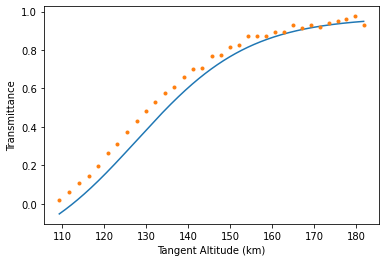

In [7]:
# Demonstration of constructing the model transmittance curve
# We must limit the domain of the fit and comparison
y_model = np.linspace(y_measured[0], y_measured[-1], 500)   # remember the domain restriction!
y50_estimated = c + 4   # our prediction is slightly different than the current estimate
plt.plot(y_model-R_planet, transmit_vs_y(y_model, a, b, y50_estimated, d))
plt.plot(y_measured-R_planet, transmit_measured, '.')
plt.ylabel("Transmittance")
plt.xlabel("Tangent Altitude (km)")

Text(0.5, 0, 'Time (sec)')

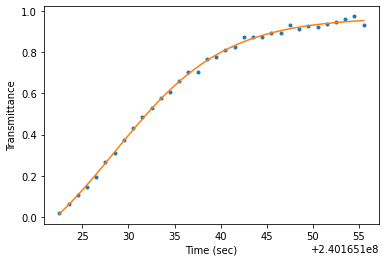

In [8]:
time_measured = time_data[w1:w2]
plt.plot(time_measured, transmit_measured, ".")
plt.plot(time_vs_y(y), transmit_model)
plt.ylabel("Transmittance")
plt.xlabel("Time (sec)")

Invert the Abel integral

In [9]:
# With the substitution y=z/(1-z)+r, we can integrate y=[r,oo] via z=[0,1]
def integrand(z, r):
    return a*b/(np.pi*(1 - z**2)*np.sqrt(-r**2 + (r + z/(1 - z))**2)*(a*np.sinh(b*(-c + r + z/(1 - z))) + d*np.cosh(b*(-c + r + z/(1 - z)))))

In [10]:
from gaussxw import gaussxwab
from scipy.integrate import quad

# Calculate sample points and weights
N=50
z, w = gaussxwab(N,0.0,1.0)
gamma_measured = np.zeros_like(y_measured)   # pseudo-density
for indx, r in enumerate(y_measured):
    s=0.0
    for k in range(N):
        s+=w[k]*integrand(z[k], r)
    gamma_measured[indx] = s

In [20]:
sigma = 1194  # [cm^2/g] at 1.5 keV

# Can we recover msis mass density?
from pymsis import msis
import datetime
import numbers

# This function gets msis density profile directly from pymsis
def get_pymsis_density(datetime, lon, lat, f107, ap, version, alts=np.arange(y_measured[0]-R_planet, y_measured[-1]-R_planet, 1.0)):
    f107a = f107
    aps = [[ap] * 7]
    output = msis.run(datetime, lon, lat, list(alts), f107, f107a, aps, version=version)

    densities = output[0, 0, 0, :, 0]  # kg/m^3
    densities = densities / 1000  # g/cm^3
    return alts, densities

# This function converts seconds from Jan 1 2014 into a datetime in UTC
def convert_time_NICER(time):
    timezero = datetime.datetime(year=2014, month=1,
                                 day=1, hour=0, minute=0, second=0)
    if isinstance(time, numbers.Real):
        new_time = timezero+datetime.timedelta(seconds=time)
        return new_time
    elif isinstance(time, list) or isinstance(time, np.ndarray):
        new_time_list = []
        for index, t in enumerate(time):
            new_time = timezero + datetime.timedelta(seconds=t)
            new_time_list.append(new_time)
        return np.array(new_time_list)
    else:
        raise RuntimeError('time must be MET number or array/list of times')

In [21]:
alts, rho = get_pymsis_density(convert_time_NICER(240165000.0), 168.7, -43.9, 75.2, 2, version=2)
n = rho*sigma   # convert to pseudo-density 'gamma' [1/cm]

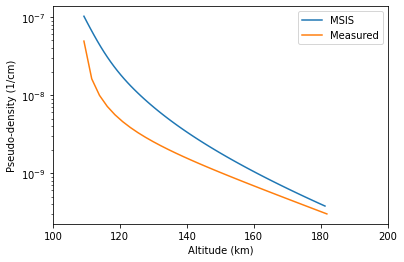

In [22]:
range_i = np.where(gamma_measured>0)[0]
plt.plot(alts, n, label="MSIS")
plt.plot(y_measured[range_i]-R_planet, gamma_measured[range_i]*10**(-5.), label="Measured")
plt.xlim([100, 200])
plt.ylabel("Pseudo-density (1/cm)")
plt.xlabel("Altitude (km)")
plt.yscale('log')
plt.legend()

In [ ]:
# Plot the fractional difference